# LSTM PRACTICAL SESSION : Mohammed-Yassine Barnicha



# Individual Household Electric Power Consumption

The **Individual Household Electric Power Consumption** dataset was donated on **August 29, 2012**. It consists of measurements of electric power consumption in a single household, with a one-minute sampling rate over a period of almost four years. The dataset includes different electrical quantities and some sub-metering values.

## Dataset Characteristics

- **Type:** Multivariate, Time-Series
- **Subject Area:** Physics and Chemistry
- **Associated Tasks:** Regression, Clustering
- **Feature Type:** Real
- **Instances:** 2,075,259
- **Features:** 9



### Has Missing Values?

Yes

## Variables Table

| Variable Name             | Role    | Type       | Description                                                           | Units       | Missing Values |
|---------------------------|---------|------------|-----------------------------------------------------------------------|-------------|----------------|
| Date                      | Feature | Date       | Date in format dd/mm/yyyy                                            |             | No             |
| Time                      | Feature | Categorical| Time in format hh:mm:ss                                              |             | No             |
| Global_active_power       | Feature | Continuous | Household global minute-averaged active power (in kilowatt)         | kilowatt    | No             |
| Global_reactive_power     | Feature | Continuous | Household global minute-averaged reactive power (in kilowatt)       | kilowatt    | No             |
| Voltage                   | Feature | Continuous | Minute-averaged voltage                                              | volts       | No             |
| Global_intensity          | Feature | Continuous | Household global minute-averaged current intensity (in ampere)      | ampere      | No             |
| Sub_metering_1           | Feature | Continuous | Energy sub-metering No. 1 (in watt-hour of active energy)           | watt-hour   | No             |
| Sub_metering_2           | Feature | Continuous | Energy sub-metering No. 2 (in watt-hour of active energy)           | watt-hour   | No             |
| Sub_metering_3           | Feature | Continuous | Energy sub-metering No. 3 (in watt-hour of active energy)           | watt-hour   | No             |



In [ ]:
import numpy
import matplotlib.pyplot as plt
import math
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

df_features  = individual_household_electric_power_consumption.data.features





C:\Users\busta\AppData\Roaming\Python\Python310\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


# Preparing the Dataset

Setting our time series target variable as $$\left( \frac{\text{global_active_power} \times 1000}{60} - \text{sub_metering_1} - \text{sub_metering_2} - \text{sub_metering_3}\right)$$ wich represents the active energy consumed every minute (in watt-hour) in the household by electrical equipment not measured in sub-meterings 1, 2, and 3.

In [ ]:
# Step 1: Convert relevant columns to numeric types
df_features['Global_active_power'] = pd.to_numeric(df_features['Global_active_power'], errors='coerce')
df_features['Sub_metering_1'] = pd.to_numeric(df_features['Sub_metering_1'], errors='coerce')
df_features['Sub_metering_2'] = pd.to_numeric(df_features['Sub_metering_2'], errors='coerce')
df_features['Sub_metering_3'] = pd.to_numeric(df_features['Sub_metering_3'], errors='coerce')


### Checking for missing values

In [ ]:
# Check for any remaining missing values after interpolation
missing_values= df_features.isna().sum()

# Display the result
print("Missing Values After Interpolation:\n", missing_values)

Missing Values After Interpolation:
 Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64


### Filling the missing values with linear interpolation, which estimates the missing values based on the surrounding data points.  :

In [ ]:
# Step 2: Handle missing values with linear interpolation
df_filled_interpolation = df_features.interpolate(method='linear')

In [ ]:
# Check for any remaining missing values after interpolation
missing_values_after_interpolation = df_filled_interpolation.isna().sum()

# Display the result
print("Missing Values After Interpolation:\n", missing_values_after_interpolation)

Missing Values After Interpolation:
 Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [ ]:
dataset=df_filled_interpolation['Global_active_power']


In [ ]:
dataset=pd.DataFrame(dataset)

In [ ]:

import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dataset.dtypes



Global_active_power    float64
dtype: object

### Scaling and splitting the data :

In [ ]:

# normalize the dataset: since timeseries are of same nature, no point in normalizing with variance.
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets (since it is a time-series you cannot split it randomly)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix that contains the ammount
#of passagers at timestep t to timestep t-lookback
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))






1390423 684836


# 1. LSTM

### 1.1 First model : (50 LSTM units , 20 epochs, batch size = 128 , learning rate =0.01)

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\busta\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(trainX, trainY, epochs=20, batch_size=128, verbose=2)

Epoch 1/20
10863/10863 - 13s - 1ms/step - loss: 7.3406e-04
Epoch 2/20
10863/10863 - 12s - 1ms/step - loss: 6.2968e-04
Epoch 3/20
10863/10863 - 12s - 1ms/step - loss: 6.2942e-04
Epoch 4/20
10863/10863 - 12s - 1ms/step - loss: 6.2906e-04
Epoch 5/20
10863/10863 - 12s - 1ms/step - loss: 6.2892e-04
Epoch 6/20
10863/10863 - 12s - 1ms/step - loss: 6.2837e-04
Epoch 7/20
10863/10863 - 12s - 1ms/step - loss: 6.2792e-04
Epoch 8/20
10863/10863 - 12s - 1ms/step - loss: 6.2767e-04
Epoch 9/20
10863/10863 - 12s - 1ms/step - loss: 6.2743e-04
Epoch 10/20
10863/10863 - 12s - 1ms/step - loss: 6.2725e-04
Epoch 11/20
10863/10863 - 12s - 1ms/step - loss: 6.2714e-04
Epoch 12/20
10863/10863 - 12s - 1ms/step - loss: 6.2685e-04
Epoch 13/20
10863/10863 - 12s - 1ms/step - loss: 6.2685e-04
Epoch 14/20
10863/10863 - 12s - 1ms/step - loss: 6.2704e-04
Epoch 15/20
10863/10863 - 12s - 1ms/step - loss: 6.2669e-04
Epoch 16/20
10863/10863 - 12s - 1ms/step - loss: 6.2670e-04
Epoch 17/20
10863/10863 - 12s - 1ms/step - loss: 

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)





43451/43451 ━━━━━━━━━━━━━━━━━━━━ 28s 648us/step
21402/21402 ━━━━━━━━━━━━━━━━━━━━ 14s 650us/step
[[ 0.00024057]
 [-0.03968706]
 [-0.02412933]
 ...
 [-0.01351864]
 [-0.01750573]
 [-0.01546587]]
[[1.32183920e+00]
 [3.03096222e-01]
 [3.04422367e-01]
 ...
 [9.65611935e-05]
 [2.16853786e-03]
 [1.68537855e-04]]


In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.28 RMSE
Test Score: 0.23 RMSE


In [ ]:
from sklearn.metrics import r2_score

# Calculate R² Score
test_r2 = r2_score(testY, testPredict)

print('Test R² Score: %.2f' % (test_r2))

Test R² Score: 0.94


#### Good results overall with better perfomance on test data (**0.23** RMSE) and excellent variance explanation with a R2 score of **0.94**

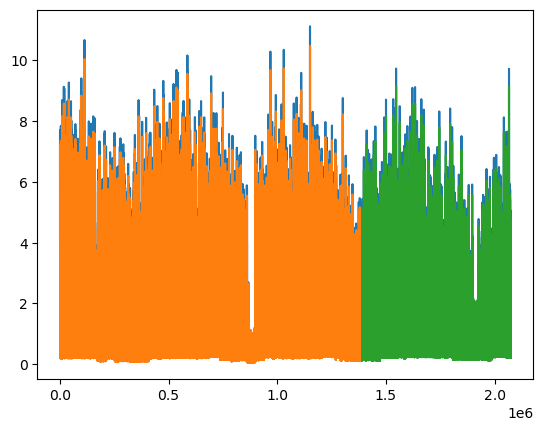

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Due to the huge amount of observations it is quite impossible to visualize the whole data once , so here you could choose your "number of points" , and our plot will be centered around the threshold between train and test for this "number of points":

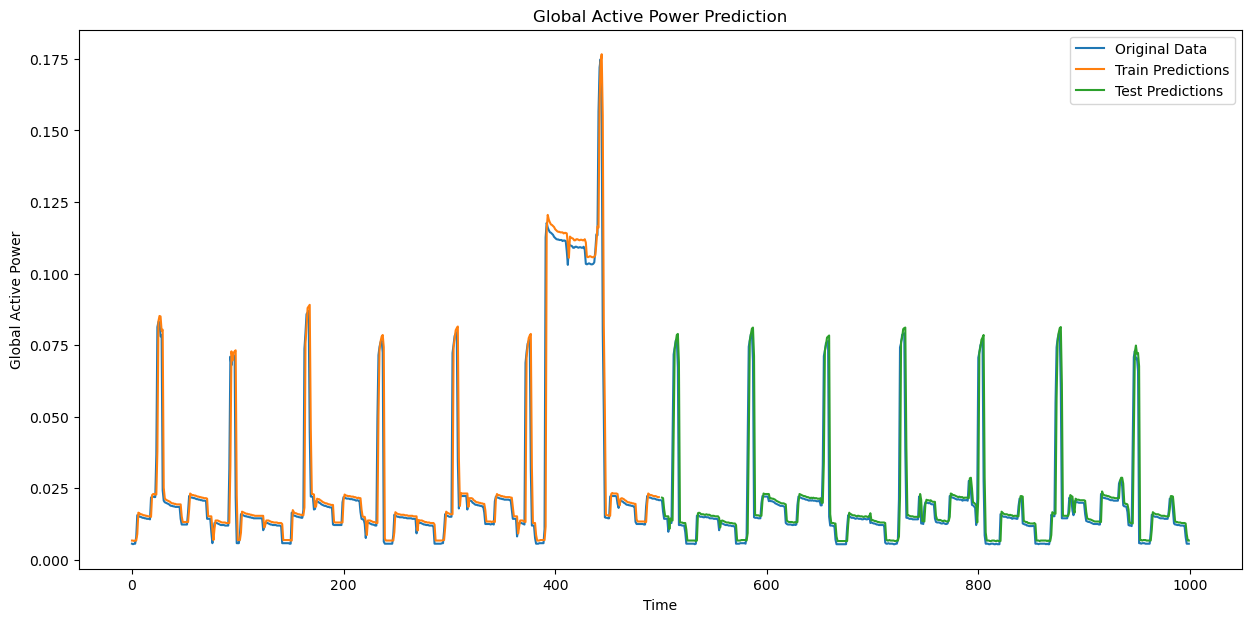

In [ ]:
T=scaler.inverse_transform(dataset)
# Assuming you already have T, trainPredictPlot, and testPredictPlot defined.

# Center around the transition point
train_size = int(len(dataset) * 0.67)
center_point = train_size
n_points = 1000

# Define m and n for plotting
m = max(0, center_point - n_points // 2)
n = min(len(T), center_point + n_points // 2)

# Improved plotting
plt.figure(figsize=(15, 7))
plt.plot(T[m:n], label='Original Data')
plt.plot(trainPredictPlot[m:n], label='Train Predictions')
plt.plot(testPredictPlot[m:n], label='Test Predictions')
plt.title('Global Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


#### The predictions appear to follow the trends of the original data closely, particularly in the test set, which suggests that the model generalizes well to unseen data.

### 1.2 Reshaping Xtrain and Xtest as it was done in the course notebook :

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))



In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\busta\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(trainX, trainY, epochs=20, batch_size=128, verbose=2)

Epoch 1/20
10863/10863 - 13s - 1ms/step - loss: 7.2440e-04
Epoch 2/20
10863/10863 - 12s - 1ms/step - loss: 6.2988e-04
Epoch 3/20
10863/10863 - 12s - 1ms/step - loss: 6.2967e-04
Epoch 4/20
10863/10863 - 12s - 1ms/step - loss: 6.2932e-04
Epoch 5/20
10863/10863 - 12s - 1ms/step - loss: 6.2873e-04
Epoch 6/20
10863/10863 - 12s - 1ms/step - loss: 6.2828e-04
Epoch 7/20
10863/10863 - 12s - 1ms/step - loss: 6.2792e-04
Epoch 8/20
10863/10863 - 12s - 1ms/step - loss: 6.2742e-04
Epoch 9/20
10863/10863 - 12s - 1ms/step - loss: 6.2761e-04
Epoch 10/20
10863/10863 - 12s - 1ms/step - loss: 6.2748e-04
Epoch 11/20
10863/10863 - 12s - 1ms/step - loss: 6.2736e-04
Epoch 12/20
10863/10863 - 12s - 1ms/step - loss: 6.2710e-04
Epoch 13/20
10863/10863 - 12s - 1ms/step - loss: 6.2694e-04
Epoch 14/20
10863/10863 - 12s - 1ms/step - loss: 6.2679e-04
Epoch 15/20
10863/10863 - 12s - 1ms/step - loss: 6.2694e-04
Epoch 16/20
10863/10863 - 12s - 1ms/step - loss: 6.2688e-04
Epoch 17/20
10863/10863 - 12s - 1ms/step - loss: 

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)





43451/43451 ━━━━━━━━━━━━━━━━━━━━ 28s 641us/step
21402/21402 ━━━━━━━━━━━━━━━━━━━━ 14s 641us/step


In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.28 RMSE
Test Score: 0.23 RMSE


In [ ]:
from sklearn.metrics import r2_score

# Calculate R² Score
test_r2 = r2_score(testY, testPredict)

print('Test R² Score: %.2f' % (test_r2))

Test R² Score: 0.94


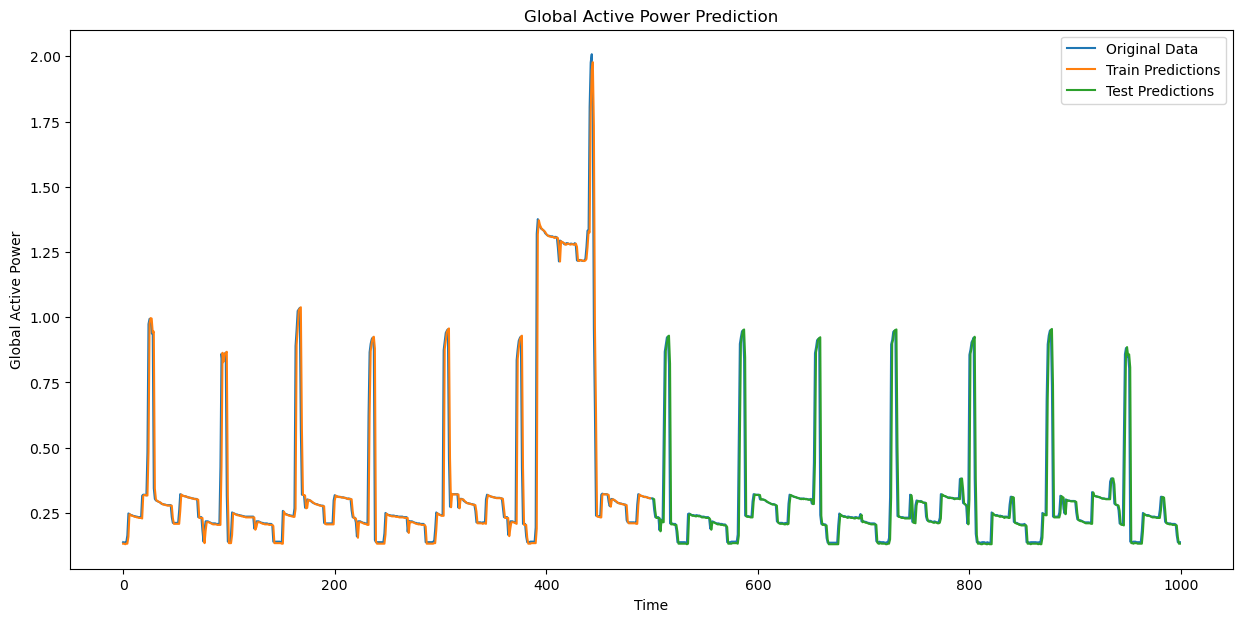

In [ ]:
T=scaler.inverse_transform(dataset)
# Assuming you already have T, trainPredictPlot, and testPredictPlot defined.

# Center around the transition point
train_size = int(len(dataset) * 0.67)
center_point = train_size
n_points = 1000

# Define m and n for plotting
m = max(0, center_point - n_points // 2)
n = min(len(T), center_point + n_points // 2)

# Improved plotting
plt.figure(figsize=(15, 7))
plt.plot(T[m:n], label='Original Data')
plt.plot(trainPredictPlot[m:n], label='Train Predictions')
plt.plot(testPredictPlot[m:n], label='Test Predictions')
plt.title('Global Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


#### the results were quite the same seeing no change in either the plots and the rmse(0.23), r2 score(0.94) .

### 1.3 Changing the lookback=3

In [ ]:
# reshape into X=t and Y=t+1
look_back = 3

In [ ]:

# normalize the dataset: since timeseries are of same nature, no point in normalizing with variance.
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets (since it is a time-series you cannot split it randomly)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix that contains the ammount
#of passagers at timestep t to timestep t-lookback
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX), numpy.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))






1390423 684836


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\busta\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(trainX, trainY, epochs=20, batch_size=128, verbose=2)

Epoch 1/20
10863/10863 - 13s - 1ms/step - loss: 6.6738e-04
Epoch 2/20
10863/10863 - 12s - 1ms/step - loss: 6.2129e-04
Epoch 3/20
10863/10863 - 12s - 1ms/step - loss: 6.2007e-04
Epoch 4/20
10863/10863 - 12s - 1ms/step - loss: 6.1901e-04
Epoch 5/20
10863/10863 - 12s - 1ms/step - loss: 6.1757e-04
Epoch 6/20
10863/10863 - 12s - 1ms/step - loss: 6.1637e-04
Epoch 7/20
10863/10863 - 12s - 1ms/step - loss: 6.1521e-04
Epoch 8/20
10863/10863 - 12s - 1ms/step - loss: 6.1401e-04
Epoch 9/20
10863/10863 - 12s - 1ms/step - loss: 6.1365e-04
Epoch 10/20
10863/10863 - 12s - 1ms/step - loss: 6.1327e-04
Epoch 11/20
10863/10863 - 12s - 1ms/step - loss: 6.1324e-04
Epoch 12/20
10863/10863 - 12s - 1ms/step - loss: 6.1315e-04
Epoch 13/20
10863/10863 - 12s - 1ms/step - loss: 6.1305e-04
Epoch 14/20
10863/10863 - 12s - 1ms/step - loss: 6.1273e-04
Epoch 15/20
10863/10863 - 12s - 1ms/step - loss: 6.1260e-04
Epoch 16/20
10863/10863 - 12s - 1ms/step - loss: 6.1254e-04
Epoch 17/20
10863/10863 - 12s - 1ms/step - loss: 

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

print(testY- testPredict)
print(trainY-trainPredict)




43451/43451 ━━━━━━━━━━━━━━━━━━━━ 28s 652us/step
21401/21401 ━━━━━━━━━━━━━━━━━━━━ 14s 666us/step
[[-1.56701152e-03]
 [ 6.86516920e-05]
 [-1.10190157e-03]
 ...
 [-1.13742271e-03]
 [-1.50328194e-03]
 [-1.26721921e-03]]
[[ 0.0360486 ]
 [-0.12800839]
 [ 0.00796992]
 ...
 [-0.00079421]
 [-0.00063093]
 [-0.00089677]]


In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.02 RMSE
Test Score: 0.02 RMSE


In [ ]:
from sklearn.metrics import r2_score

# Calculate R² Score
test_r2 = r2_score(testY, testPredict)

print('Test R² Score: %.2f' % (test_r2))

Test R² Score: 0.94


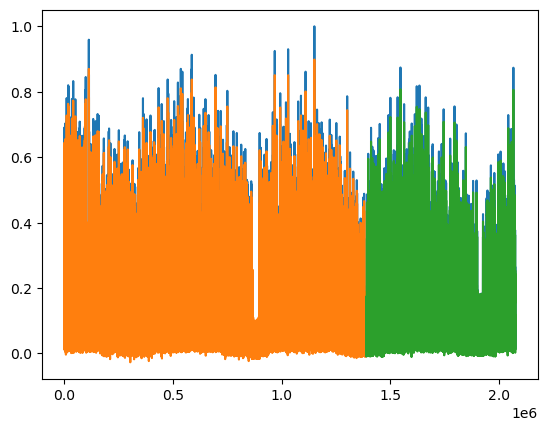

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

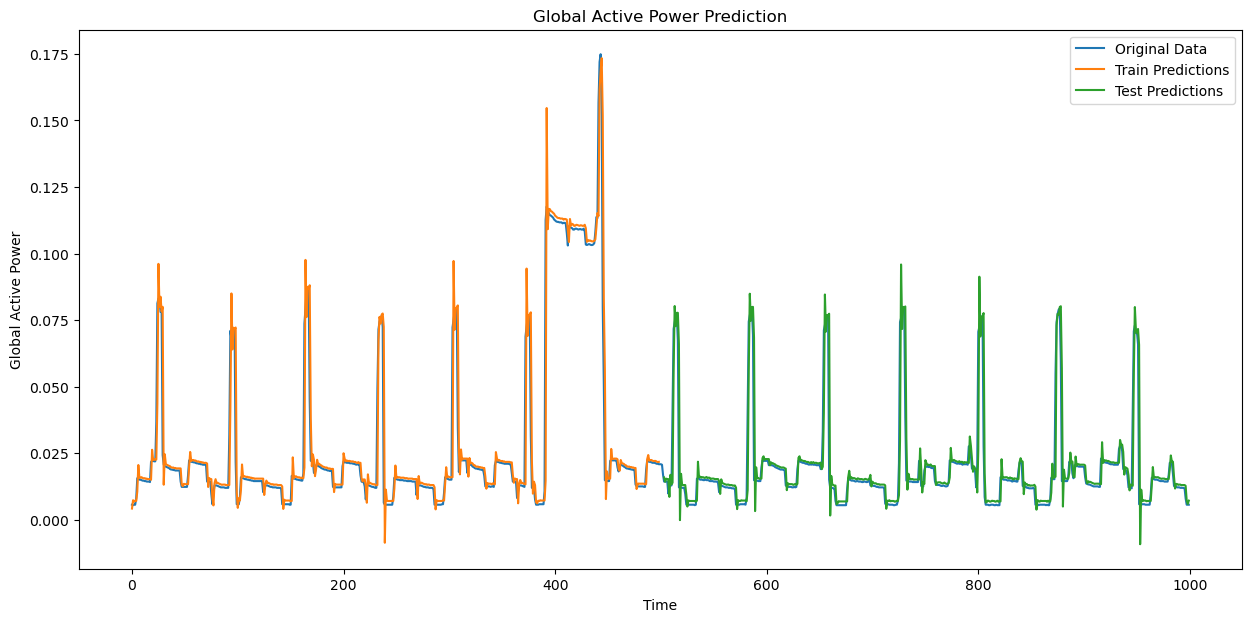

In [ ]:
T=scaler.inverse_transform(dataset)
# Assuming you already have T, trainPredictPlot, and testPredictPlot defined.

# Center around the transition point
train_size = int(len(dataset) * 0.67)
center_point = train_size
n_points = 1000

# Define m and n for plotting
m = max(0, center_point - n_points // 2)
n = min(len(T), center_point + n_points // 2)

# Improved plotting
plt.figure(figsize=(15, 7))
plt.plot(T[m:n], label='Original Data')
plt.plot(trainPredictPlot[m:n], label='Train Predictions')
plt.plot(testPredictPlot[m:n], label='Test Predictions')
plt.title('Global Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


In this analysis, we adjusted the `look_back` parameter to 3 for our LSTM model to improve the prediction of global active power consumption.

#### Results

- **Train Score (RMSE):** 0.02
- **Test Score (RMSE):** 0.02
- **Test R² Score:** 0.94

#### Observations

1. **RMSE Values:** The low RMSE values for both training and testing datasets indicate that the predictions are very close to the actual values, suggesting high accuracy in the model's performance.

2. **R² Score:** The R² score of 0.94 signifies that the model explains 94% of the variance in the test data, reflecting its ability to generalize well to unseen data.

3. **Visual Comparison:** The updated plot below illustrates how the train and test predictions align closely with the original data, demonstrating that increasing the look back period has enhanced the model's ability to capture temporal dependencies.


# 1D CONVOLUTIONAL NEURAL NETWORK (CNN)

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [ ]:

# normalize the dataset: since timeseries are of same nature, no point in normalizing with variance.
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets (since it is a time-series you cannot split it randomly)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix that contains the ammount
#of passagers at timestep t to timestep t-lookback
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))




1390423 684836


#### CNN Model Architecture
The CNN model consists of a **1D convolutional layer** with **64 filters** and a **kernel size of 1**, using **ReLU** activation. The output is then flattened to prepare for the dense layers. Following this, a **dense layer with 50 neurons** and **ReLU** activation is added, leading to a **final output layer with one neuron**. The model is compiled using the **Adam** optimizer and **mean squared error** as the loss function.

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(look_back, trainX.shape[2])))
model.add(Flatten())  # Flatten instead of MaxPooling
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\busta\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Step 2: Train the model
# Train the model
model.fit(trainX, trainY, epochs=20, batch_size=64, verbose=2)

Epoch 1/20
21726/21726 - 20s - 939us/step - loss: 6.4980e-04
Epoch 2/20
21726/21726 - 20s - 899us/step - loss: 6.3378e-04
Epoch 3/20
21726/21726 - 19s - 894us/step - loss: 6.3310e-04
Epoch 4/20
21726/21726 - 20s - 921us/step - loss: 6.3230e-04
Epoch 5/20
21726/21726 - 20s - 923us/step - loss: 6.3171e-04
Epoch 6/20
21726/21726 - 20s - 912us/step - loss: 6.3051e-04
Epoch 7/20
21726/21726 - 20s - 913us/step - loss: 6.3024e-04
Epoch 8/20
21726/21726 - 20s - 905us/step - loss: 6.3003e-04
Epoch 9/20
21726/21726 - 20s - 900us/step - loss: 6.2999e-04
Epoch 10/20
21726/21726 - 19s - 888us/step - loss: 6.2980e-04
Epoch 11/20
21726/21726 - 19s - 891us/step - loss: 6.2984e-04
Epoch 12/20
21726/21726 - 19s - 883us/step - loss: 6.2944e-04
Epoch 13/20
21726/21726 - 19s - 887us/step - loss: 6.2899e-04
Epoch 14/20
21726/21726 - 19s - 897us/step - loss: 6.2864e-04
Epoch 15/20
21726/21726 - 20s - 929us/step - loss: 6.2877e-04
Epoch 16/20
21726/21726 - 19s - 884us/step - loss: 6.2858e-04
Epoch 17/20
21726

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)





43451/43451 ━━━━━━━━━━━━━━━━━━━━ 31s 706us/step
21402/21402 ━━━━━━━━━━━━━━━━━━━━ 15s 693us/step


In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.02 RMSE
Test Score: 0.02 RMSE


In [ ]:
from sklearn.metrics import r2_score

# Calculate R² Score
test_r2 = r2_score(testY, testPredict)

print('Test R² Score: %.2f' % (test_r2))

Test R² Score: 0.94


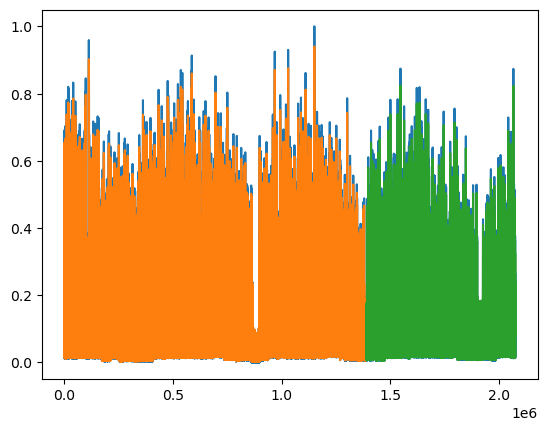

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

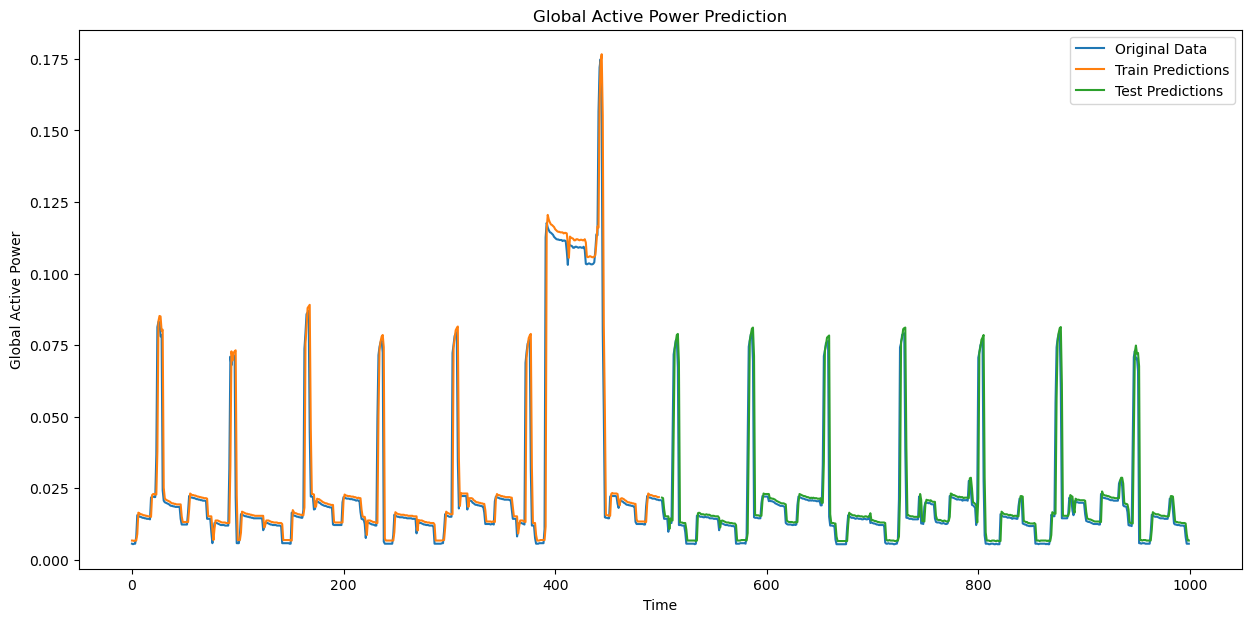

In [ ]:
T=scaler.inverse_transform(dataset)
# Assuming you already have T, trainPredictPlot, and testPredictPlot defined.

# Center around the transition point
train_size = int(len(dataset) * 0.67)
center_point = train_size
n_points = 1000

# Define m and n for plotting
m = max(0, center_point - n_points // 2)
n = min(len(T), center_point + n_points // 2)

# Improved plotting
plt.figure(figsize=(15, 7))
plt.plot(T[m:n], label='Original Data')
plt.plot(trainPredictPlot[m:n], label='Train Predictions')
plt.plot(testPredictPlot[m:n], label='Test Predictions')
plt.title('Global Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


### Observations

- **RMSE Values:** Low RMSE values indicate excellent predictive accuracy, with predictions closely aligning with actual values.
- **R² Score:** An R² score of 0.94 shows the model explains 94% of the variance in the test dataset, highlighting strong generalization.
- **Visual Comparison:** The plot demonstrates that train and test predictions closely follow the original data, confirming the model effectively captures essential patterns.


### Conclusion

In comparing the models, both the LSTM and CNN demonstrate strong predictive performance, achieving low RMSE values of 0.02 for both training and testing datasets. The R² scores are consistently high, at 0.94, indicating that both models explain a significant portion of the variance in the test data. However, the CNN model, with a look back of 1, shows remarkable efficiency in capturing essential patterns with fewer time steps, suggesting it may offer advantages in computational efficiency while maintaining accuracy. Overall, both models effectively model global active power consumption, but the CNN may provide a more streamlined approach.
